# Clothes Classifier

In [1]:
from fastai import *
from fastai.vision import *

## Get Data

In [2]:
classes = ['jeans','trousers','jacket', 'shorts', 'tshirt', 'buttonup']
path = Path('data/clothes')

# Create folder structure
for folder in classes:
    file = "urls_" + folder + ".csv"
    
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/folder/file, dest, max_pics=500)

# Clean invalid images
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

jeans


trousers


jacket


shorts


tshirt


buttonup


## Stage 1

(['buttonup', 'jacket', 'jeans', 'shorts', 'trousers', 'tshirt'], 6, 1536, 384)

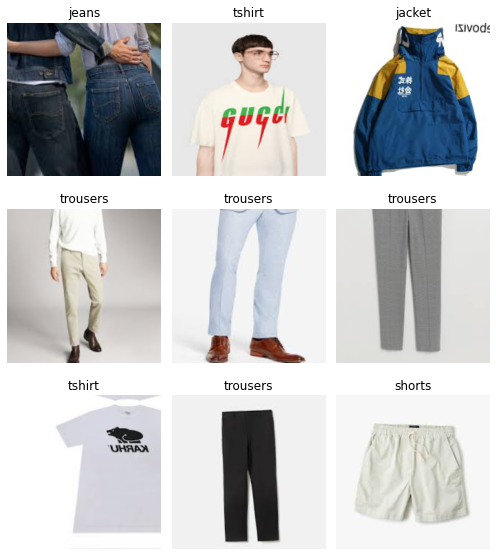

In [3]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

data.classes

data.show_batch(rows=3, figsize=(7,8))
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [4]:
learner = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [5]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.824298,0.660916,0.223958,0.776042,00:05
1,1.191093,0.651023,0.208333,0.791667,00:05
2,0.913073,0.657344,0.205729,0.794271,00:04
3,0.724107,0.650779,0.200521,0.799479,00:04


In [6]:
learner.save('stage-1')

In [7]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

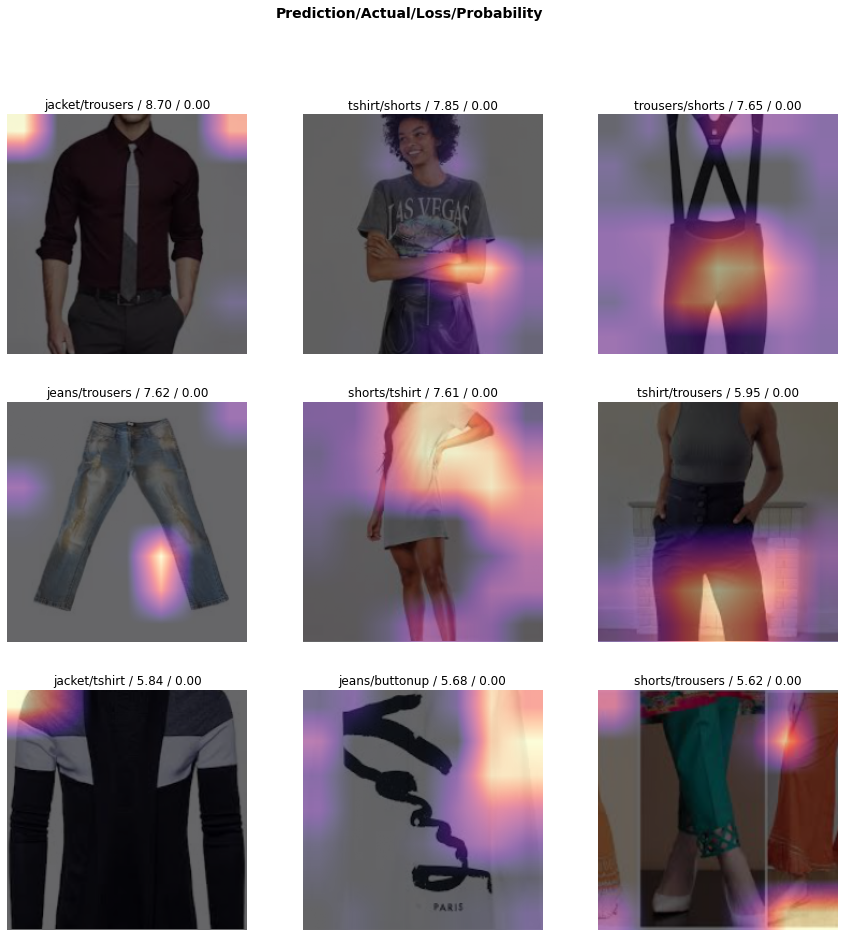

In [8]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)

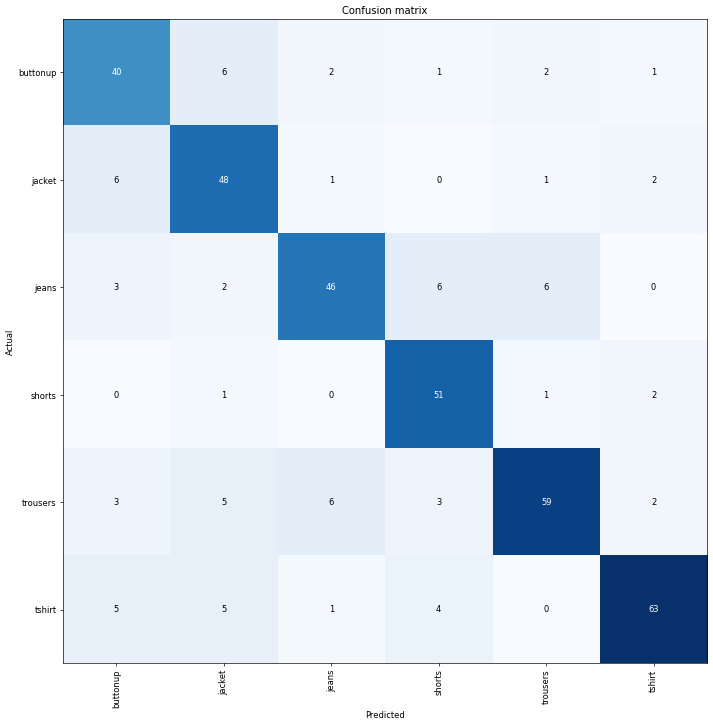

In [9]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Stage 2

In [10]:
learner.load('stage-1');

In [11]:
learner.unfreeze()

In [12]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


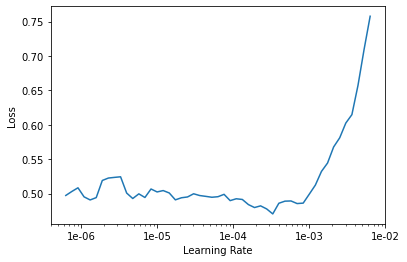

In [13]:
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(8, max_lr=slice(5e-6,5e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.533614,0.621081,0.192708,0.807292,00:05
1,0.467748,0.579228,0.171875,0.828125,00:05
2,0.404444,0.532523,0.161458,0.838542,00:05
3,0.346786,0.499419,0.143229,0.856771,00:05
4,0.295804,0.523742,0.153646,0.846354,00:05
5,0.243560,0.515696,0.151042,0.848958,00:05
6,0.209845,0.516585,0.145833,0.854167,00:05
7,0.189863,0.524380,0.145833,0.854167,00:05


In [15]:
learner.save('stage-2')

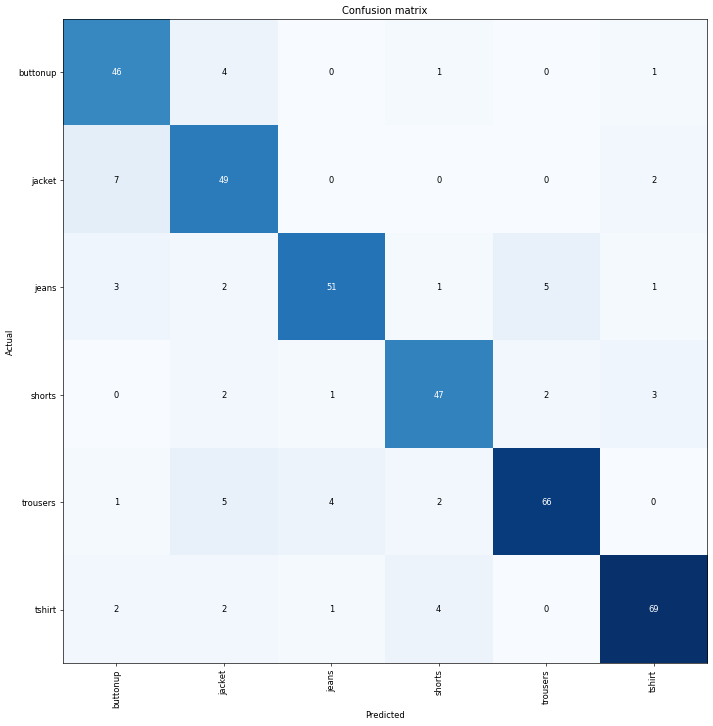

In [16]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()
# interp.plot_top_losses(9, figsize=(15,15), heatmap=True)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Cleanup

In [57]:
from fastai.widgets import *

### Top Losses 

In [58]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [59]:
learn_clean = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_clean.load('stage-2');

In [60]:
ds, idxs = DatasetFormatter().from_toplosses(learn_clean)

In [61]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Duplicates

In [62]:
# Load data from the new cleaned.csv
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [63]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
     )

In [64]:
learn_clean = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_clean.load('stage-2');

In [65]:
ds, idxs = DatasetFormatter().from_similars(learn_clean)

Getting activations...


Computing similarities...


In [66]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Retrain

(['buttonup', 'jacket', 'jeans', 'shorts', 'trousers', 'tshirt'], 6, 1505, 376)

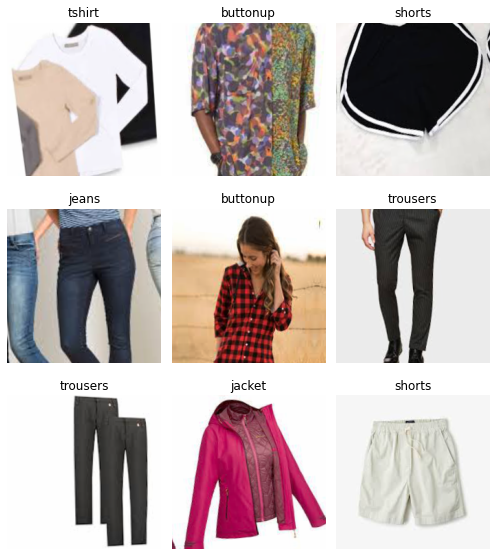

In [67]:
# Load data from the new cleaned.csv
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

data.classes

data.show_batch(rows=3, figsize=(7,8))
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [89]:
learner = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [90]:
learner.fit_one_cycle(6, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.016953,0.771312,0.247340,0.752660,00:04
1,1.267480,0.795515,0.223404,0.776596,00:04
2,0.903128,0.630688,0.172872,0.827128,00:04
3,0.683163,0.608132,0.199468,0.800532,00:05
4,0.519732,0.563776,0.170213,0.829787,00:05
5,0.437815,0.560526,0.167553,0.832447,00:04


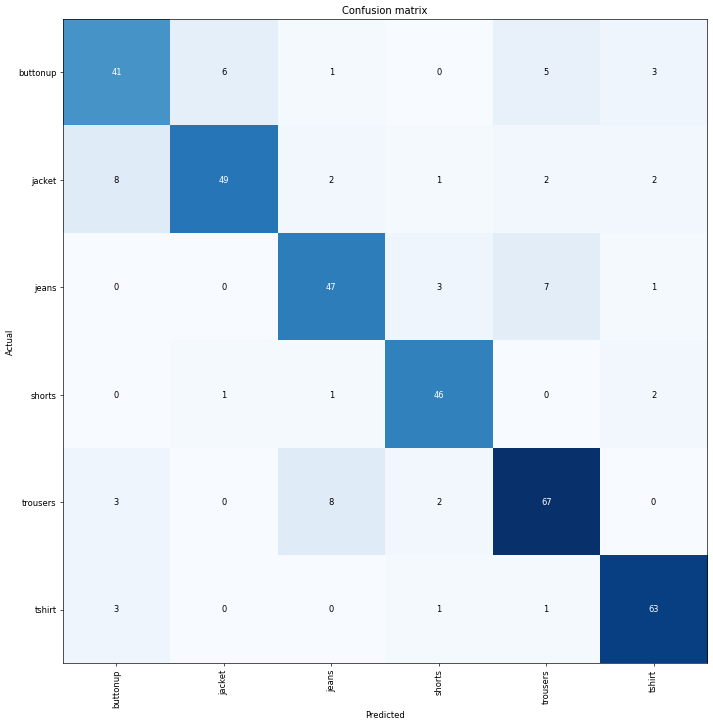

In [91]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

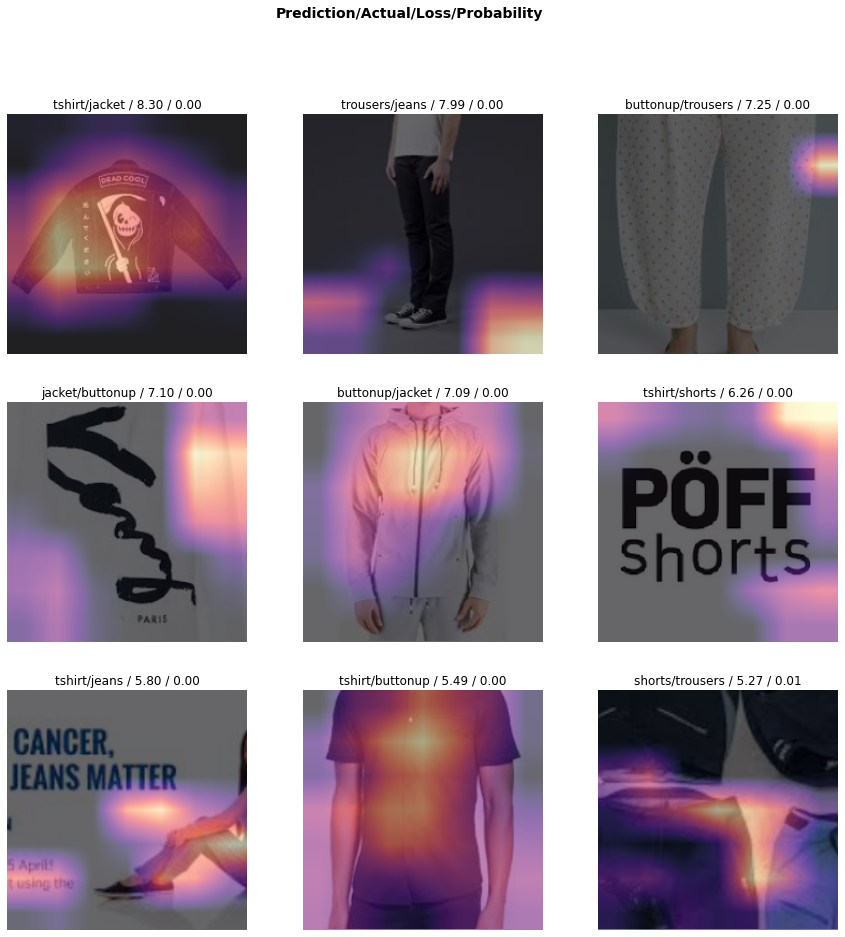

In [92]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)

In [93]:
learner.unfreeze()

In [94]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


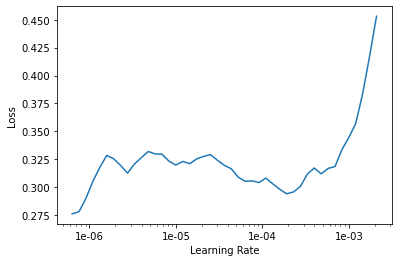

In [95]:
learner.recorder.plot()

In [96]:
learner.save('stage-3')

In [101]:
learner.load('stage-3');

In [103]:
learner.fit_one_cycle(4, max_lr=slice(6e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.172988,0.539221,0.162234,0.837766,00:05
1,0.161609,0.519343,0.148936,0.851064,00:05
2,0.154847,0.500238,0.138298,0.861702,00:05
3,0.147072,0.495017,0.140957,0.859043,00:05


In [104]:
learner.save('stage-4')

## Production

In [105]:
learner.export()